Code attempt for https://arxiv.org/pdf/2111.06969v1.pdf

In [1]:
import numpy as np
from scipy.stats import binom, bernoulli
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt

##State-space and Memory list

###Distance and similarity

In [2]:
'''
Parameters
'''
N = 100 # dimension
p = 0.5 # probability of Bernoulli rv == 0
kappa = 2

'''
State-space
'''
def _distance(x, y):
    return hamming(x, y)

def _similarity(d):
    '''
    The Hamming distance of two random binary strings follows a Binomial distribution
    '''
    return np.exp(-1 * kappa * binom.cdf(d*N, N, 0.5))


###Let's explore the state-space
Does our distance metric of choice make sense?

In the paper, the author mentions: "*In a probabilistic setting, two points are the more difficult to distinguish, the less likely it is to find another state at random which is ’in between’ the two*". What does it mean to have a state "in between" two states?

Let's explore the state-space for a lower dimension (because cross products only work for 2 or 3 dim).

In [3]:
!pip install pyro-ppl

     |████████████████████████████████| 713 kB 4.7 MB/s 


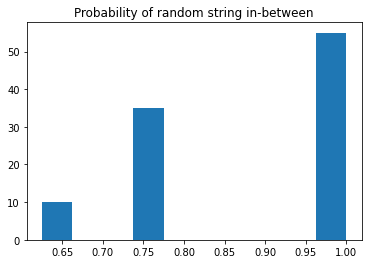

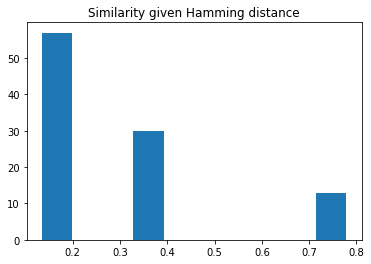

In [4]:
import itertools
import torch
from pyro.infer import Importance, EmpiricalMarginal

n = 3
all_binstrs = np.array(list(itertools.product([0,1], repeat=n)))

def between_states():
    count = 0
    states = np.random.randint(0,2,size=(2, n)) # Create a random pair of binary strings
    for binstr in all_binstrs:
        # Determine if {binstr} is in between the pair
        if np.dot(np.cross(states[0], states[1]),np.cross(states[0], binstr)) >= 0 and \
        np.dot(np.cross(binstr,states[1]), np.cross(binstr,states[0])) >= 0:
            count += 1
    return torch.tensor(count/2**n) # probability a random string is between the pair

posterior = Importance(between_states, guide=None, num_samples=100)
marginal = EmpiricalMarginal(posterior.run())
plt.hist([marginal().item() for _ in range(100)])
plt.title('Probability of random string in-between');
plt.show()

def similar():
    states = np.random.randint(0,2,size=(2, n)) # Create a random pair of binary strings
    d = _distance(states[0], states[1])
    return torch.tensor(np.exp(-1 * kappa * binom.cdf(d*n, n, 0.5)))

posterior = Importance(similar, guide=None, num_samples=100)
marginal = EmpiricalMarginal(posterior.run())
plt.hist([marginal().item() for _ in range(100)])
plt.title('Similarity given Hamming distance')
plt.show()

As we can see, the two distributions have an inverse relationship: the more similar the two states are, the less likely it is to find a state in between them. Therefore, the Hamming distance is a valid choice.

###Defining operations and activation

In [5]:
'''
Operations
'''
def _mult(x, y):
    '''
    Binding: the multiplication operation is an element-wise negation of XOR
    '''
    return (x == y).astype(int)

def _add(x, y):
    '''
    Bundling: the addition operation with probability p
    '''
    def unit_add(a, b):
        return a if a == b else bernoulli.rvs(1-p)
    return np.vectorize(unit_add)(x,y)

'''
Memory list
'''
def L(lst):
    '''
    Left-associative addition
    '''
    if len(lst) == 1:
        return lst[0]
    return _add(L(lst[:-1]), lst[-1])

def R(lst):
    '''
    Right-associative addition
    '''
    if len(lst) == 1:
        return lst[0]
    return _add(lst[0], R(lst[1:]))

def generate_data(length):
    data = np.zeros((1, N)) # initialize with state 0s
    data = np.append(data, np.random.randint(0,2,size=(length, N)), axis=0) # 0 and 1s
    return data

def distance_activation(mem_list, mem_state):
    dist, sim = [], []
    for state in mem_list[1:]: # eta doesn't need to be plotted
        d = _distance(state, mem_state)
        dist.append(d)
        sim.append(_similarity(d))
    return dist, sim

'''
Simulation
'''
def simulate(length, degree=0):
    '''
    Simulate random data of {length} memory items over 1000 trials
    With {degree} neighbouring similarity from B, e.g. B~C, B~D, ...
    '''
    dL, dR = [], [] # distances
    aL, aR = [], [] # ctivations (similarity)

    for i in range(1000):
        data = generate_data(length)
        data[degree+2] = data[2]
        distL, simL = distance_activation(data, L(data))
        distR, simR = distance_activation(data, R(data))
        dL.append(distL)
        dR.append(distR)
        aL.append(simL)
        aR.append(simR)
    return dL, dR, aL, aR

###Plotting distance

In [6]:
dL, dR, aL, aR = simulate(7)

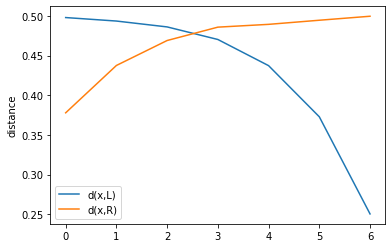

In [7]:
plt.plot(np.mean(dL,axis=0), label='d(x,L)')
plt.plot(np.mean(dR,axis=0), label='d(x,R)')
plt.legend();
plt.ylabel('distance');
plt.savefig('distance.png')

###Plotting activation

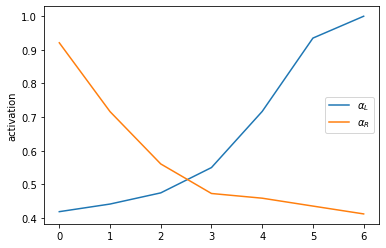

In [8]:
# L implies a recency gradient αL , while R implies a primacy gradient αR
plt.plot(np.mean(aL,axis=0), label=r'$\alpha_L$')
plt.plot(np.mean(aR,axis=0), label=r'$\alpha_R$')
plt.legend();
plt.ylabel('activation');
plt.savefig('activation.png')

##Response function for recognition and recall

###The recency effect does not depend on list length 

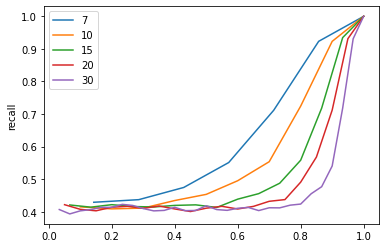

In [9]:
for length in [7, 10, 15, 20, 30]:
    _, _, aL, _ = simulate(length)
    plt.plot((np.arange(length)+1)/length, np.mean(aL, axis=0), label=length) # scale plots
plt.legend();
plt.ylabel('recall');
plt.savefig('recall.png')

###Repetition
The effect of similar items on activation

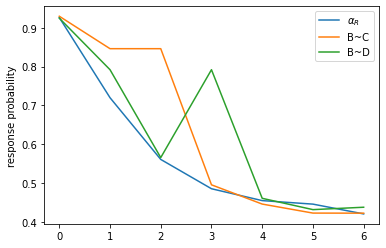

In [10]:
_, _, _, aR0 = simulate(7, 0)
_, _, _, aR1 = simulate(7, 1) # B ~ C
_, _, _, aR2 = simulate(7, 2) # B ~ D
plt.plot(np.mean(aR0, axis=0), label=r'$\alpha_R$')
plt.plot(np.mean(aR1, axis=0), label='B~C')
plt.plot(np.mean(aR2, axis=0), label='B~D')
plt.legend();
plt.ylabel('response probability');
plt.savefig('repetition.png')

###Cued recall

In [11]:
def binded(lst1, lst2):
    '''
    Paired memory list [a-x, b-y, c-z, ...]
    R = eta + a * x + b * y + c * z + ...
    '''
    memlst = _mult(lst1, lst2) # element-wise binding
    memlst = np.append(np.zeros((1, N)), memlst, axis=0) # append eta in beginning of each list
    return memlst

def simulate_binded(length, degree=0):
    aR, xaR, yaR, zaR = [], [], [], [] # activations (similarity)

    for i in range(1000):
        A = np.random.randint(0,2,size=(length,N)) # [a, b, c, ...]
        X = np.random.randint(0,2,size=(length,N)) # [x, y, z, ...]
        X[degree] = X[0] # e.g. c ~ a
        data = binded(A, X)     
        dataA = np.append(np.zeros((1, N)), A, axis=0) # append eta
        _, simR = distance_activation(data, R(data))
        _, simRx = distance_activation(dataA, _mult(X[0],R(data))) # x * R
        _, simRy = distance_activation(dataA, _mult(X[1],R(data))) # y * R
        _, simRz = distance_activation(dataA, _mult(X[2],R(data))) # z * R
        aR.append(simR)
        xaR.append(simRx) 
        yaR.append(simRy)
        zaR.append(simRz)
    return aR, xaR, yaR, zaR

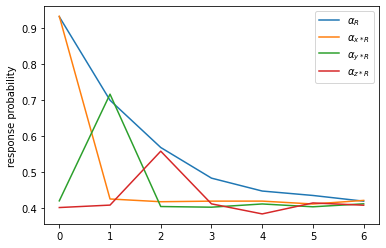

In [12]:
aR, xaR, yaR, zaR = simulate_binded(7)

plt.plot(np.mean(aR, axis=0), label=r'$\alpha_R$')
plt.plot(np.mean(xaR, axis=0), label=r'$\alpha_{x*R}$')
plt.plot(np.mean(yaR, axis=0), label=r'$\alpha_{y*R}$')
plt.plot(np.mean(zaR, axis=0), label=r'$\alpha_{z*R}$')
plt.legend();
plt.ylabel('response probability');
plt.savefig('cued_recall.png')

###Retrieval from similar contexts

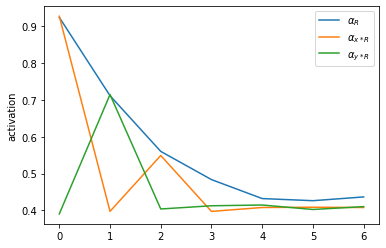

In [13]:
# Let A and C be bound to similar contexts
aR, xaR, yaR, _ = simulate_binded(7, 2)

plt.plot(np.mean(aR, axis=0), label=r'$\alpha_R$')
plt.plot(np.mean(xaR, axis=0), label=r'$\alpha_{x*R}$')
plt.plot(np.mean(yaR, axis=0), label=r'$\alpha_{y*R}$')
plt.legend();
plt.ylabel('activation');
plt.savefig('similar_retrieval.png')

##Putting thing together: Serial position curve

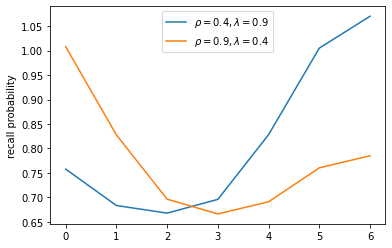

In [14]:
def serial(rho, lamb):
    _, _, aL, aR = simulate(7)
    return rho*np.array(aR) + lamb*np.array(aL)

rho, lamb = 0.4, 0.9
plt.plot(np.mean(serial(rho, lamb), axis=0), label=r'$\rho={{{}}}, \lambda={{{}}}$'.format(rho, lamb))
rho, lamb = 0.9, 0.4
plt.plot(np.mean(serial(rho, lamb), axis=0), label=r'$\rho={{{}}}, \lambda={{{}}}$'.format(rho, lamb))
plt.legend();
plt.ylabel('recall probability');
plt.savefig('serial.png')